# Epidemia Data Cleaning and Analysis
### Sneha Sridhar, Agnibho Roy

In [1]:
#import necessary libraries and modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

In [66]:
#load data into dataframes
covid_cases = pd.read_csv("data/covid_cases_county.csv")
covid_deaths = pd.read_csv("data/covid_deaths_county.csv")
covid_recovered_g = pd.read_csv("data/covid_recovered_global.csv")
covid_census = pd.read_csv("data/census_county.csv", encoding='latin-1')
covid_locations = pd.read_csv("data/county_locations.csv")

## 1. Preliminary Visualization

We want to first see whether or not the cases and deaths in the united states accross all of the counties does indeed resemble an SIRD model. Below shows a plot of cases and deaths over time (measured in days after 1/22/2020)

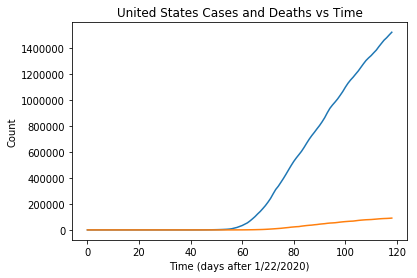

In [3]:
#visualization of cumulative counts to see similarity to SIDS model
cases_cumulative = []
deaths_cumulative = []
for column in covid_cases.columns[4:]:
    cases_cumulative.append(np.sum(covid_cases[column]))
    deaths_cumulative.append(np.sum(covid_deaths[column]))
    
plt.plot(np.arange(len(cases_cumulative)), cases_cumulative)
plt.plot(np.arange(len(deaths_cumulative)), deaths_cumulative)
plt.title("United States Cases and Deaths vs Time")
plt.xlabel("Time (days after 1/22/2020)")
plt.ylabel("Count")
plt.show()

## 2. Data Cleaning

We now proceed with data cleaning where we only choose the necessarily information from each of the tables loaded. This means choosing columns, combining and joining data, and interpolation of datasets that we do not have the granularity of county-level data (ex. recovered individuals is only provided per nation). there are a few key data structures that are outputted which are to be used by the model:

1. `covid_data`: Nested dictionaries that provide a heirarchy of data. The first level has `stateFIPS` as the keys, which maps to the second level dictionary, which has `countyFIPS` as the keys, which maps to the third level dictionary, which has `date` as the keys, which maps to the fourth level dictionary, which has the `cases`, `deaths`, and `recovered` as keys, which each map to their respective values. To see what the county and state names `stateFIPS` and `countyFIPS` map to, use the lookup dictionaries in part (4) and (5). 
2. `population_data`: Nested dictionaries that provide a heirarchy of data. The first level has `stateFIPS` as the keys, which maps to the second level dictionary, which has `countyFIPS` as the keys, which maps to the third level dictionary, which has the `birth_rate`, `death_rate` (will be scaled to a daily value to provide the parameters $\lambda_{i}$ and $\mu_{i}$ in our model, respectively.), and `total_pop` as keys, which each map to their respective values. To see what the county and state names `stateFIPS` and `countyFIPS` map to, use the lookup dictionaries in part (4) and (5). 
3. `location_data`: Nested dictionaries that provide a heirarchy of data. The first level has `countyFIPS` as the keys, which maps to the second level dictionary, which has the `latitude` and `longitude` as keys, each mapping to their respective values.
4. `FIPS_to_state`: Lookup dictionary mapping `stateFIPS` to `state`
5. `FIPS_to_county`: Lookup dictionary mapping `countyFIPS` to `county`

In [45]:
covid_census_cleaned = covid_census.loc[:, [col for col in covid_census.columns[:7]] + ["POPESTIMATE2019", "BIRTHS2019", "DEATHS2019"]]
covid_recovered_US = covid_recovered_g[covid_recovered_g["Country/Region"] == "US"]

#creating recovered table by scaling number infected for each county
covid_recovered = {}
for column in covid_cases.columns[:4]:
    covid_recovered[column] = covid_cases.loc[:, column].values
for date in covid_cases.columns[4:]:
    cases_singleday_scaled = np.array(covid_cases.loc[:, date]) / np.sum(covid_cases.loc[:, date])
    recovered_singleday = covid_recovered_US.loc[:, date].values[0] * cases_singleday_scaled
    covid_recovered[date] = recovered_singleday.astype(int)
covid_recovered = pd.DataFrame(data=covid_recovered)

In [26]:
#creating data_final structure holding cases, deaths, recovered, etc. in nested dicts
covid_data = {}
for state_id in covid_cases.loc[:, "stateFIPS"].unique():
    state_cases = covid_cases[covid_cases["stateFIPS"] == state_id]
    state_deaths = covid_deaths[covid_deaths["stateFIPS"] == state_id]
    state_recovered = covid_recovered[covid_recovered["stateFIPS"] == state_id]
    county_final = {}
    for county_id in state_cases.loc[:, "countyFIPS"].unique():
        county_cases = state_cases[state_cases["countyFIPS"] == county_id]
        county_deaths = state_deaths[state_deaths["countyFIPS"] == county_id]
        county_recovered = state_recovered[state_recovered["countyFIPS"] == county_id]
        stats_by_date = {}
        for date in covid_cases.columns[4:]:
            stats_single = {}
            stats_single["cases"] = county_cases.loc[:, date].values[0]
            stats_single["deaths"] = county_deaths.loc[:, date].values[0]
            stats_single["recovered"] = county_recovered.loc[:, date].values[0]
            stats_by_date[date] = stats_single
        county_final[county_id] = stats_by_date
    covid_data[state_id] = county_final

In [71]:
#creating population_data to keep each county's birth and death rate, along with the total population for 2019
population_data = {}
for state_id in covid_census_cleaned.loc[:, "STATE"].unique():
    state_pop_data = covid_census_cleaned[covid_census_cleaned["STATE"] == state_id]
    county_final = {}
    for county_id in state_pop_data.loc[:, "COUNTY"].unique():
        county_pop_data = state_pop_data[state_pop_data["COUNTY"] == county_id]
        stats_pop = {}
        stats_pop["total_pop"] = county_pop_data.loc[:, "POPESTIMATE2019"].values[0]
        stats_pop["birth_rate"] = county_pop_data.loc[:, "BIRTHS2019"].values[0] / stats_pop["total_pop"]
        stats_pop["death_rate"] = county_pop_data.loc[:, "DEATHS2019"].values[0] / stats_pop["total_pop"]
        county_final[county_id + state_id * 1000] = stats_pop
    population_data[state_id] = county_final  

In [74]:
#creating location_data to keep latitude and longitude information for diffusion matrices
location_data = {}
county_id = np.array(covid_locations.loc[:, "FIPS"]).astype(int)
latitudes = np.array(covid_locations.loc[:, "Lat"])
longitudes = np.array(covid_locations.loc[:, "Long_"])
for i in range(len(county_id)):
    county_data = {}
    county_data["lat"] = latitudes.item(i)
    county_data["long"] = longitudes.item(i)
    location_data[county_id.item(i)] = county_data

In [75]:
#creating lookup tables as mentioned in parts (3) and (4)
FIPS_to_state = {}
FIPS_to_county = {}
stateFIPS = np.array(covid_cases.loc[:, "stateFIPS"])
countyFIPS = np.array(covid_cases.loc[:, "countyFIPS"])
state_name = np.array(covid_cases.loc[:, "State"])
county_name = np.array(covid_cases.loc[:, "County Name"])
for i in range(len(stateFIPS)):
    FIPS_to_state[stateFIPS.item(i)] = state_name.item(i)
    FIPS_to_county[countyFIPS.item(i)] = county_name.item(i)